In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from typing import Tuple

In [3]:
def classify_cortisol_level(value):
    if value > 20:
        return "High"
    elif value < 10:
        return "Low"
    else:
        return "Moderate"

In [4]:
def classify_iga_level(avg):
    if avg > 100:
        return "High IgA"
    elif avg < 30:
        return "Low IgA"
    else:
        return "Moderate IgA"

In [5]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """
    from scipy.stats import mannwhitneyu

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "negligible"
    elif abs_rbc < 0.3:
        interpretation = "small"
    elif abs_rbc < 0.5:
        interpretation = "medium"
    else:
        interpretation = "large"

    return rbc, interpretation

In [6]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "negligible"
    elif abs_delta < 0.33:
        interpretation = "small"
    elif abs_delta < 0.474:
        interpretation = "medium"
    else:
        interpretation = "large"
    return delta, interpretation

In [7]:
df_data = pd.read_csv("../processed_data/2_processed_data_cortisol.csv")
df_data.head(5)

,Sample,Cortisol (pg/mL),Attachment,Gender,IgA D1-Morning,IgA D1-Afternoon,IgA D2-Morning,IgA D2-Afternoon,Average IgA Morning,Average IgA Afternoon,Average Difference IgA
0,38,4.21,Secure,NaN,58.086780,51.030042,38.632819,36.767491,48.359800,43.898767,-4.461033
1,16,3.59,Secure,Female,79.173752,108.512940,35.780159,39.270931,57.476955,73.891936,16.414980
2,32,22.75,Secure,Male,21.135748,58.108226,43.994904,31.113912,32.565326,44.611069,12.045743
3,1,5.62,Insecure,Male,20.076728,31.719207,23.453752,25.016903,21.765240,28.368055,6.602815
4,7,1.83,Insecure,Female,26.747838,47.213491,21.599136,35.942378,24.173487,41.577934,17.404447


In [8]:
df_data.shape

(10, 11)

In [9]:
df_data["Attachment"].value_counts()

Secure      6
Insecure    4
Name: Attachment, dtype: int64

In [10]:
df_data_clean = df_data.dropna()
df_data_clean.shape

(8, 11)

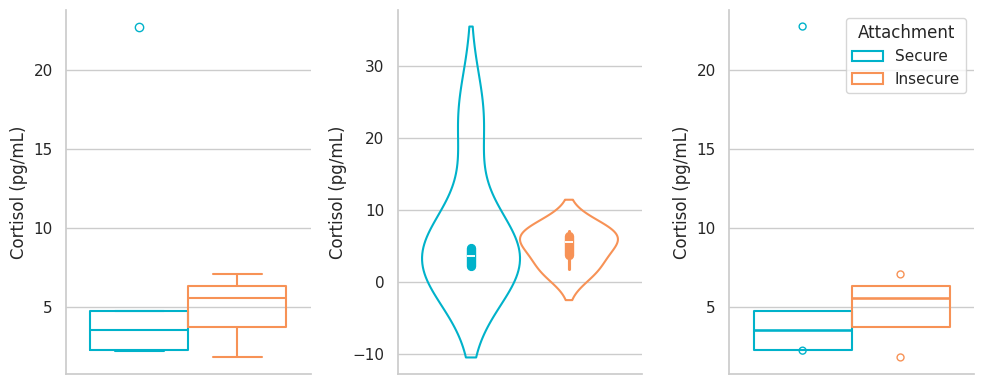

In [11]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_clean, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_data_clean, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxenplot(
    data=df_data_clean, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

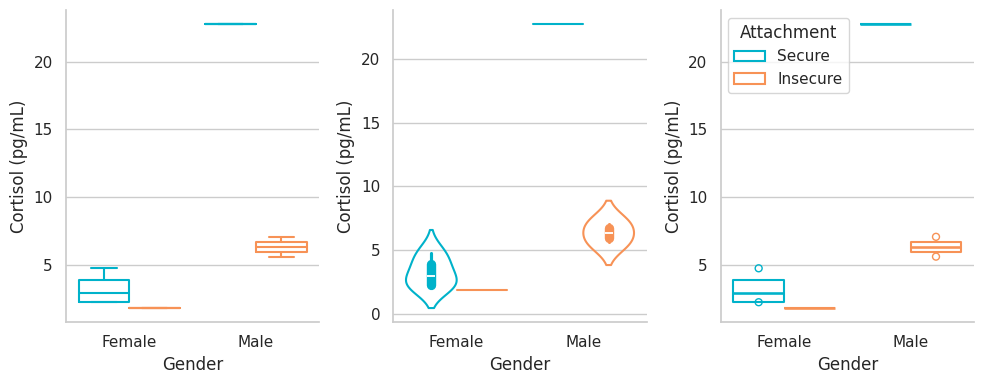

In [12]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_clean, 
    y="Cortisol (pg/mL)", 
    x="Gender",
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.violinplot(
    data=df_data_clean, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[1], 
    x="Gender",
    fill=False, 
    palette=palette,
    legend=False)

sns.boxenplot(
    data=df_data_clean, 
    y="Cortisol (pg/mL)", 
    hue="Attachment", 
    x="Gender",
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

In [13]:
iga_vars = ["Average IgA Morning", "Average IgA Afternoon", "Average Difference IgA", "Cortisol (pg/mL)"]

gender_results = []
for var in iga_vars:
    male_vals = df_data_clean[df_data_clean["Gender"] == "Male"][var]
    female_vals = df_data_clean[df_data_clean["Gender"] == "Female"][var]
    stat, p = mannwhitneyu(male_vals, female_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    gender_results.append(statistic_result)

gender_results = pd.DataFrame(gender_results)
gender_results["reject"] = gender_results["p-value"]<=0.05
gender_results

,variable,U statistic,p-value,reject
0,Average IgA Morning,2.0,0.142857,False
1,Average IgA Afternoon,1.0,0.071429,False
2,Average Difference IgA,8.0,1.000000,False
3,Cortisol (pg/mL),15.0,0.035714,True


In [14]:
attachment_results = []
for var in iga_vars:
    secure_vals = df_data_clean[df_data_clean["Attachment"] == "Secure"][var]
    insecure_vals = df_data_clean[df_data_clean["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_results.append(statistic_result)

attachment_results = pd.DataFrame(attachment_results)
attachment_results["reject"] = attachment_results["p-value"]<=0.05
attachment_results

,variable,U statistic,p-value,reject
0,Average IgA Morning,15.0,0.035714,True
1,Average IgA Afternoon,15.0,0.035714,True
2,Average Difference IgA,5.0,0.571429,False
3,Cortisol (pg/mL),7.0,1.000000,False


In [15]:
df_data_clean["Group"] = df_data_clean["Attachment"] + " - " + df_data_clean["Gender"]

iga_vars = [
    "Average IgA Morning",
    "Average IgA Afternoon",
    "Average Difference IgA",
    "Cortisol (pg/mL)"
]

kruskal_results = {}
for var in iga_vars:
    data = [group[var].values for name, group in df_data_clean.groupby("Group")]
    stat, p = kruskal(*data)
    kruskal_results[var] = {"H statistic": stat, "p-value": p}
kruskal_df = pd.DataFrame(kruskal_results).T

print("=== Kruskal–Wallis Results ===")
print(kruskal_df)

# Post-hoc Dunn test with Holm correction
print("\n=== Dunn's Test (Holm-corrected p-values) ===")
for var in iga_vars:
    print(f"\n--- {var} ---")
    posthoc = sp.posthoc_dunn(
        df_data_clean,
        val_col=var,
        group_col="Group",
        p_adjust='holm'
    )
    print(posthoc)

=== Kruskal–Wallis Results ===
                        H statistic   p-value
Average IgA Morning        5.833333  0.120007
Average IgA Afternoon      6.083333  0.107626
Average Difference IgA     3.166667  0.366635
Cortisol (pg/mL)           6.083333  0.107626

=== Dunn's Test (Holm-corrected p-values) ===

--- Average IgA Morning ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female           1.000000         1.000000         0.501741   
Insecure - Male             1.000000         1.000000         0.203369   
Secure - Female             0.501741         0.203369         1.000000   
Secure - Male               1.000000         1.000000         1.000000   

                   Secure - Male  
Insecure - Female            1.0  
Insecure - Male              1.0  
Secure - Female              1.0  
Secure - Male                1.0  

--- Average IgA Afternoon ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - F

In [16]:
gender_cliffs = []
for var in iga_vars:
    male = df_data_clean[df_data_clean["Gender"] == "Male"][var]
    female = df_data_clean[df_data_clean["Gender"] == "Female"][var]
    delta, interp = cliffs_delta(male, female)
    gender_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

gender_cliffs = pd.DataFrame(gender_cliffs)
gender_cliffs

,variable,Cliff's Delta,Interpretation
0,Average IgA Morning,-0.733333,large
1,Average IgA Afternoon,-0.866667,large
2,Average Difference IgA,0.066667,negligible
3,Cortisol (pg/mL),1.000000,large


In [17]:
attachment_cliffs = []
for var in iga_vars:
    secure = df_data_clean[df_data_clean["Attachment"] == "Secure"][var]
    insecure = df_data_clean[df_data_clean["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(insecure, secure)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,Average IgA Morning,-1.000000,large
1,Average IgA Afternoon,-1.000000,large
2,Average Difference IgA,0.333333,medium
3,Cortisol (pg/mL),0.066667,negligible


In [18]:
combined_cliffs = {}
grouped = df_data_clean.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    delta, interp = cliffs_delta(data1, data2)
                    results[var] = {"Cliff's Delta": delta, "Interpretation": interp}
            combined_cliffs[label] = results

combined_cliffs_df = pd.concat({k: pd.DataFrame(v).T for k, v in combined_cliffs.items()}, names=["Group Comparison", "Variable"])
combined_cliffs_df

Cliff's Delta  \
Group Comparison                               Variable                               
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning              0.0   
                                               Average IgA Afternoon            1.0   
                                               Average Difference IgA           1.0   
                                               Cortisol (pg/mL)                -1.0   
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning             -1.0   
                                               Average IgA Afternoon           -1.0   
                                               Average Difference IgA           1.0   
                                               Cortisol (pg/mL)                -1.0   
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning             -1.0   
                                               Average IgA Afternoon           -1.0   
                                               Average Difference IgA           1.0   
                                               Cortisol (pg/mL)                -1.0   
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning             -1.0   
                                               Average IgA Afternoon           -1.0   
                                               Average Difference IgA          0.25   
                                               Cortisol (pg/mL)                 1.0   
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning             -1.0   
                                               Average IgA Afternoon           -1.0   
                                               Average Difference IgA          -1.0   
                                               Cortisol (pg/mL)                -1.0   
('Secure', 'Female') vs ('Secure', 'Male')     Average IgA Morning              1.0   
                                               Average IgA Afternoon            1.0   
                                               Average Difference IgA          -0.5   
                                               Cortisol (pg/mL)                -1.0   

                                                                      Interpretation  
Group Comparison                               Variable                               
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning        negligible  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          small  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference I

In [19]:
rbc_gender = []
for var in iga_vars:
    male = df_data_clean[df_data_clean["Gender"] == "Male"][var]
    female = df_data_clean[df_data_clean["Gender"] == "Female"][var]
    rbc, interp = rank_biserial_correlation(male, female)
    rbc_gender.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_gender = pd.DataFrame(rbc_gender)
rbc_gender

,variable,Rank-Biserial Corr,Interpretation
0,Average IgA Morning,0.733333,large
1,Average IgA Afternoon,0.866667,large
2,Average Difference IgA,-0.066667,negligible
3,Cortisol (pg/mL),-1.000000,large


In [20]:
rbc_attachment = []
for var in iga_vars:
    secure = df_data_clean[df_data_clean["Attachment"] == "Secure"][var]
    insecure = df_data_clean[df_data_clean["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure, insecure)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,Average IgA Morning,-1.000000,large
1,Average IgA Afternoon,-1.000000,large
2,Average Difference IgA,0.333333,medium
3,Cortisol (pg/mL),0.066667,negligible


In [21]:
rbc_combined = {}
grouped = df_data_clean.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    rbc, interp = rank_biserial_correlation(data1, data2)
                    results[var] = {"Rank-Biserial Corr": rbc, "Interpretation": interp}
            rbc_combined[label] = results

rbc_combined_df = pd.concat({k: pd.DataFrame(v).T for k, v in rbc_combined.items()}, names=["Group Comparison", "Variable"])
rbc_combined_df

Rank-Biserial Corr  \
Group Comparison                               Variable                                    
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning                   0.0   
                                               Average IgA Afternoon                -1.0   
                                               Average Difference IgA               -1.0   
                                               Cortisol (pg/mL)                      1.0   
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning                   1.0   
                                               Average IgA Afternoon                 1.0   
                                               Average Difference IgA               -1.0   
                                               Cortisol (pg/mL)                      1.0   
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning                   1.0   
                                               Average IgA Afternoon                 1.0   
                                               Average Difference IgA               -1.0   
                                               Cortisol (pg/mL)                      1.0   
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning                   1.0   
                                               Average IgA Afternoon                 1.0   
                                               Average Difference IgA              -0.25   
                                               Cortisol (pg/mL)                     -1.0   
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning                   1.0   
                                               Average IgA Afternoon                 1.0   
                                               Average Difference IgA                1.0   
                                               Cortisol (pg/mL)                      1.0   
('Secure', 'Female') vs ('Secure', 'Male')     Average IgA Morning                  -1.0   
                                               Average IgA Afternoon                -1.0   
                                               Average Difference IgA                0.5   
                                               Cortisol (pg/mL)                      1.0   

                                                                      Interpretation  
Group Comparison                               Variable                               
('Insecure', 'Female') vs ('Insecure', 'Male') Average IgA Morning        negligible  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Female') vs ('Secure', 'Female') Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Female') vs ('Secure', 'Male')   Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          large  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Male') vs ('Secure', 'Female')   Average IgA Morning             large  
                                               Average IgA Afternoon           large  
                                               Average Difference IgA          small  
                                               Cortisol (pg/mL)                large  
('Insecure', 'Male') vs ('Secure', 'Male')     Average IgA Morning             large  
                        

In [22]:
gender_results.merge(right=gender_cliffs, on="variable").merge(right=rbc_gender, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,Average IgA Morning,2.0,0.142857,False,-0.733333,large,0.733333,large
1,Average IgA Afternoon,1.0,0.071429,False,-0.866667,large,0.866667,large
2,Average Difference IgA,8.0,1.000000,False,0.066667,negligible,-0.066667,negligible
3,Cortisol (pg/mL),15.0,0.035714,True,1.000000,large,-1.000000,large


In [23]:
attachment_results.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,Average IgA Morning,15.0,0.035714,True,-1.000000,large,-1.000000,large
1,Average IgA Afternoon,15.0,0.035714,True,-1.000000,large,-1.000000,large
2,Average Difference IgA,5.0,0.571429,False,0.333333,medium,0.333333,medium
3,Cortisol (pg/mL),7.0,1.000000,False,0.066667,negligible,0.066667,negligible


In [24]:
df_data_clean.head(5)

,Sample,Cortisol (pg/mL),Attachment,Gender,IgA D1-Morning,IgA D1-Afternoon,IgA D2-Morning,IgA D2-Afternoon,Average IgA Morning,Average IgA Afternoon,Average Difference IgA,Group
1,16,3.59,Secure,Female,79.173752,108.512940,35.780159,39.270931,57.476955,73.891936,16.414980,Secure - Female
2,32,22.75,Secure,Male,21.135748,58.108226,43.994904,31.113912,32.565326,44.611069,12.045743,Secure - Male
3,1,5.62,Insecure,Male,20.076728,31.719207,23.453752,25.016903,21.765240,28.368055,6.602815,Insecure - Male
4,7,1.83,Insecure,Female,26.747838,47.213491,21.599136,35.942378,24.173487,41.577934,17.404447,Insecure - Female
6,5,2.28,Secure,Female,161.424693,46.867951,39.006348,52.728307,100.215520,49.798129,-50.417391,Secure - Female


In [25]:
df_data_clean["Variability_Profile"] = df_data_clean["Average Difference IgA"].apply(
    lambda x: "High variability" if x > 50 else "Low/Moderate"
)

df_data_clean["IgA_Level_Profile_Morning"] = df_data_clean["Average IgA Morning"].apply(classify_iga_level)
df_data_clean["IgA_Level_Profile_Afternoon"] = df_data_clean["Average IgA Afternoon"].apply(classify_iga_level)
df_data_clean.head(5)

,Sample,Cortisol (pg/mL),Attachment,Gender,IgA D1-Morning,IgA D1-Afternoon,IgA D2-Morning,IgA D2-Afternoon,Average IgA Morning,Average IgA Afternoon,Average Difference IgA,Group,Variability_Profile,IgA_Level_Profile_Morning,IgA_Level_Profile_Afternoon
1,16,3.59,Secure,Female,79.173752,108.512940,35.780159,39.270931,57.476955,73.891936,16.414980,Secure - Female,Low/Moderate,Moderate IgA,Moderate IgA
2,32,22.75,Secure,Male,21.135748,58.108226,43.994904,31.113912,32.565326,44.611069,12.045743,Secure - Male,Low/Moderate,Moderate IgA,Moderate IgA
3,1,5.62,Insecure,Male,20.076728,31.719207,23.453752,25.016903,21.765240,28.368055,6.602815,Insecure - Male,Low/Moderate,Low IgA,Low IgA
4,7,1.83,Insecure,Female,26.747838,47.213491,21.599136,35.942378,24.173487,41.577934,17.404447,Insecure - Female,Low/Moderate,Low IgA,Moderate IgA
6,5,2.28,Secure,Female,161.424693,46.867951,39.006348,52.728307,100.215520,49.798129,-50.417391,Secure - Female,Low/Moderate,High IgA,Moderate IgA


In [26]:
df_data_clean.shape

(8, 15)

In [27]:
df_data_clean["Variability_Profile"].value_counts()

Low/Moderate    8
Name: Variability_Profile, dtype: int64

In [28]:
df_data_clean["IgA_Level_Profile_Morning"].value_counts()

Moderate IgA    4
Low IgA         3
High IgA        1
Name: IgA_Level_Profile_Morning, dtype: int64

In [29]:
df_data_clean["IgA_Level_Profile_Afternoon"].value_counts()

Moderate IgA    6
Low IgA         2
Name: IgA_Level_Profile_Afternoon, dtype: int64

In [30]:
changing_data = []
for index in df_data_clean.index:
    change = ""
    morning = df_data_clean["IgA_Level_Profile_Morning"][index]
    afternoon = df_data_clean["IgA_Level_Profile_Afternoon"][index]

    if morning == afternoon:
        change = "No Change"
    elif (morning == "Low IgA" and afternoon in ["Moderate IgA", "High IgA"]) or (morning == "Moderate IgA" and afternoon == "High IgA"):
        change = "Increase"
    elif (morning == "Moderate IgA" and afternoon == "Low IgA") or (morning == "High IgA" and afternoon == "Moderate IgA"):
        change = "Decrease"
    else:
        change = "check"
    
    changing_data.append(change)

df_data_clean["IgA-Change"] = changing_data
df_data_clean["IgA-Change"].value_counts()

No Change    6
Increase     1
Decrease     1
Name: IgA-Change, dtype: int64

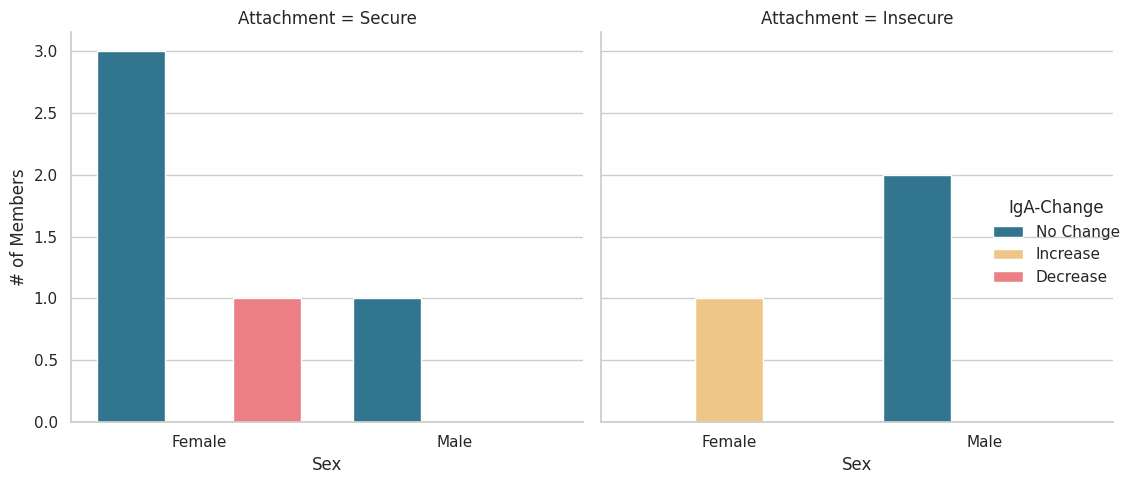

In [31]:
g = sns.catplot(
    data=df_data_clean,
    kind="count",
    x="Gender",
    hue="IgA-Change",
    col="Attachment",
    palette=["#227C9D", "#FFCB77", "#FE6D73"]
)

g.set_axis_labels("Sex", "# of Members")
g._legend.set_title("IgA-Change")
plt.tight_layout()
plt.show()

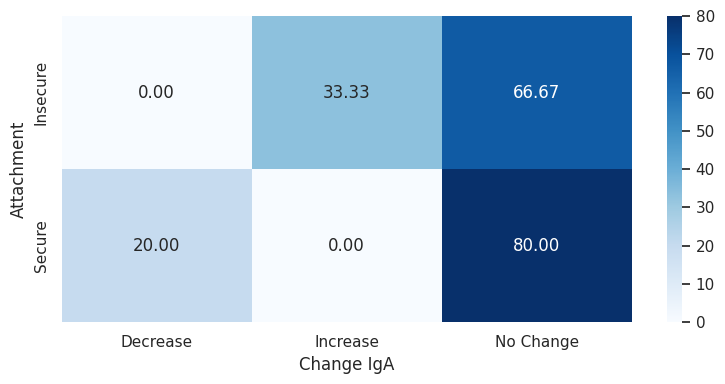

In [32]:
heat_data = pd.crosstab(df_data_clean["Attachment"], df_data_clean["IgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Attachment")
plt.xlabel("Change IgA")
plt.tight_layout()
plt.show()

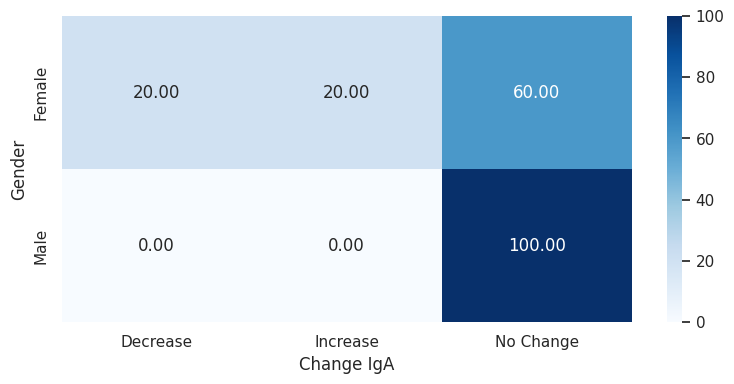

In [33]:
heat_data = pd.crosstab(df_data_clean["Gender"], df_data_clean["IgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Gender")
plt.xlabel("Change IgA")
plt.tight_layout()
plt.show()

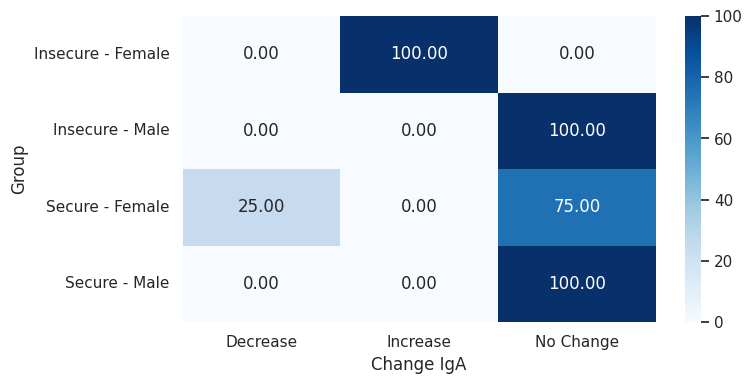

In [34]:
heat_data = pd.crosstab(df_data_clean["Group"], df_data_clean["IgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Group")
plt.xlabel("Change IgA")
plt.tight_layout()
plt.show()

In [35]:
df_data_clean.columns

Index(['Sample', 'Cortisol (pg/mL)', 'Attachment', 'Gender', 'IgA D1-Morning',
       'IgA D1-Afternoon', 'IgA D2-Morning', 'IgA D2-Afternoon',
       'Average IgA Morning', 'Average IgA Afternoon',
       'Average Difference IgA', 'Group', 'Variability_Profile',
       'IgA_Level_Profile_Morning', 'IgA_Level_Profile_Afternoon',
       'IgA-Change'],
      dtype='object')

In [36]:
df_data_clean["Cortisol_Level"] = df_data_clean["Cortisol (pg/mL)"].apply(classify_cortisol_level)
df_data_clean["Cortisol_Level"].value_counts()

Low     7
High    1
Name: Cortisol_Level, dtype: int64

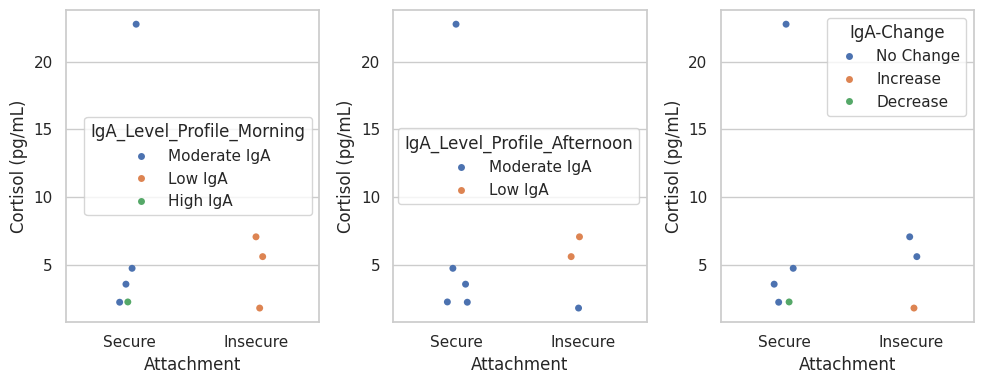

In [37]:
f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.stripplot(ax=axes[0], data=df_data_clean, x="Attachment", y="Cortisol (pg/mL)", hue="IgA_Level_Profile_Morning")
sns.stripplot(ax=axes[1], data=df_data_clean, x="Attachment", y="Cortisol (pg/mL)", hue="IgA_Level_Profile_Afternoon")
sns.stripplot(ax=axes[2], data=df_data_clean, x="Attachment", y="Cortisol (pg/mL)", hue="IgA-Change")

plt.tight_layout()

<Axes: xlabel='Attachment', ylabel='Cortisol (pg/mL)'>

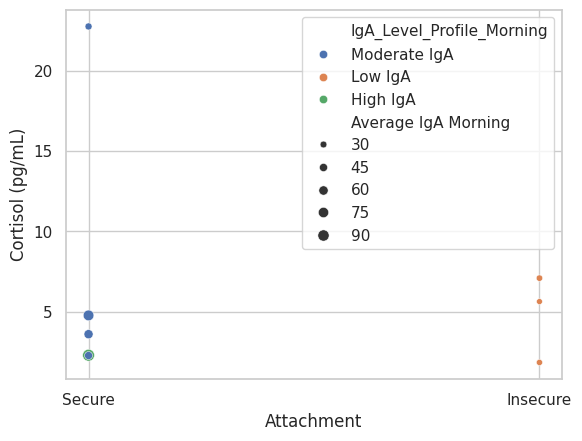

In [38]:
sns.scatterplot(
    data=df_data_clean,
    x="Attachment",
    y="Cortisol (pg/mL)",
    size="Average IgA Morning",
    hue="IgA_Level_Profile_Morning"
)

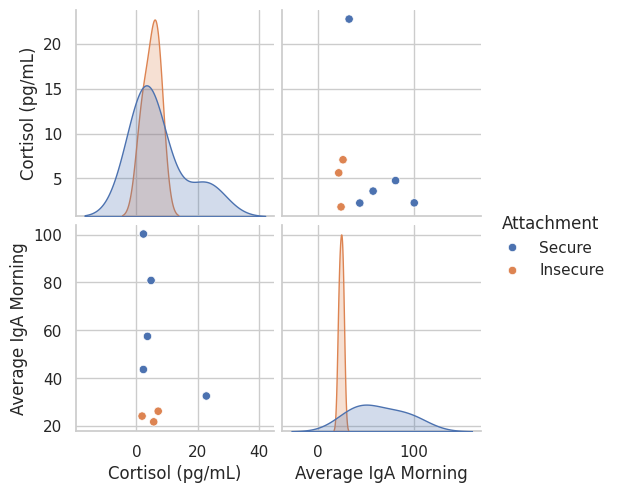

In [39]:
sns.pairplot(df_data_clean, hue="Attachment", vars=["Cortisol (pg/mL)", "Average IgA Morning"])

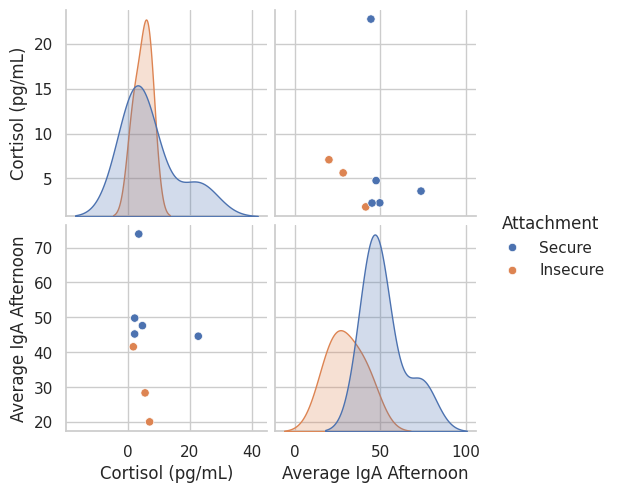

In [40]:
sns.pairplot(df_data_clean, hue="Attachment", vars=["Cortisol (pg/mL)", "Average IgA Afternoon"])

In [41]:
df_data_clean

,Sample,Cortisol (pg/mL),Attachment,Gender,IgA D1-Morning,IgA D1-Afternoon,IgA D2-Morning,IgA D2-Afternoon,Average IgA Morning,Average IgA Afternoon,Average Difference IgA,Group,Variability_Profile,IgA_Level_Profile_Morning,IgA_Level_Profile_Afternoon,IgA-Change,Cortisol_Level
1,16,3.59,Secure,Female,79.173752,108.512940,35.780159,39.270931,57.476955,73.891936,16.414980,Secure - Female,Low/Moderate,Moderate IgA,Moderate IgA,No Change,Low
2,32,22.75,Secure,Male,21.135748,58.108226,43.994904,31.113912,32.565326,44.611069,12.045743,Secure - Male,Low/Moderate,Moderate IgA,Moderate IgA,No Change,High
3,1,5.62,Insecure,Male,20.076728,31.719207,23.453752,25.016903,21.765240,28.368055,6.602815,Insecure - Male,Low/Moderate,Low IgA,Low IgA,No Change,Low
4,7,1.83,Insecure,Female,26.747838,47.213491,21.599136,35.942378,24.173487,41.577934,17.404447,Insecure - Female,Low/Moderate,Low IgA,Moderate IgA,Increase,Low
6,5,2.28,Secure,Female,161.424693,46.867951,39.006348,52.728307,100.215520,49.798129,-50.417391,Secure - Female,Low/Moderate,High IgA,Moderate IgA,Decrease,Low
7,63,7.08,Insecure,Male,24.012107,21.808747,28.427144,18.324096,26.219626,20.066422,-6.153204,Insecure - Male,Low/Moderate,Low IgA,Low IgA,No Change,Low
8,27,2.26,Secure,Female,53.147518,37.759187,34.127202,52.728307,43.637360,45.243747,1.606387,Secure - Female,Low/Moderate,Moderate IgA,Moderate IgA,No Change,Low
9,23,4.76,Secure,Female,78.975857,56.250589,82.673910,39.015096,80.824884,47.632842,-33.192041,Secure - Female,Low/Moderate,Moderate IgA,Moderate IgA,No Change,Low
